In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#KPM Evaluation
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score
import json
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



ֿ** loading predictions:
Checkpoint 129: mAP strict = 0.6497972579828272, mAP relaxed = 0.7926099677128807

ֿ** loading predictions:
Checkpoint 258: mAP strict = 0.782247894921018, mAP relaxed = 0.8884351024031404

ֿ** loading predictions:
Checkpoint 387: mAP strict = 0.8160382402316996, mAP relaxed = 0.9329860986509605

ֿ** loading predictions:
Checkpoint 516: mAP strict = 0.8164880645976877, mAP relaxed = 0.9363571135850873

ֿ** loading predictions:
Checkpoint 645: mAP strict = 0.8178718476618592, mAP relaxed = 0.9368942896320466


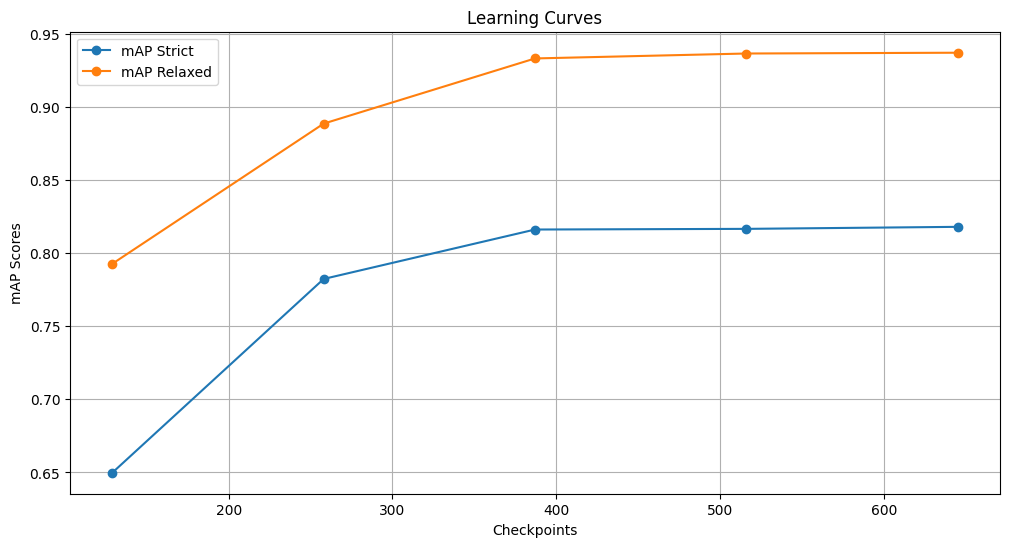

In [10]:
def load_kpm_data(gold_data_dir, subset):
    arguments_file = os.path.join(gold_data_dir, f"arguments_human_translated_{subset}.csv")
    key_points_file = os.path.join(gold_data_dir, f"key_points_human_translated_{subset}.csv")
    labels_file = os.path.join(gold_data_dir, f"labels_{subset}.csv")
    arguments_df = pd.read_csv(arguments_file)
    key_points_df = pd.read_csv(key_points_file)
    labels_file_df = pd.read_csv(labels_file)
    return arguments_df, key_points_df, labels_file_df

def load_predictions(predictions_dir, correct_kp_list):
    arg =[]
    kp = []
    scores = []
    invalid_keypoints = set()
    with open(predictions_dir, "r") as f_in:
        res = json.load(f_in)
        for arg_id, kps in res.items():
            valid_kps = {key: value for key, value in kps.items() if key in correct_kp_list}
            invalid = {key: value for key, value in kps.items() if key not in correct_kp_list}
            for invalid_kp, _ in invalid.items():
                if invalid_kp not in invalid_keypoints:
                    #print(f"key point {invalid_kp} doesn't appear in the key points file and will be ignored")
                    invalid_keypoints.add(invalid_kp)
            if valid_kps:
                best_kp = max(valid_kps.items(), key=lambda x: x[1])
                arg.append(arg_id)
                kp.append(best_kp[0])
                scores.append(best_kp[1])
        #print(f"\tloaded predictions for {len(arg)} arguments")

        return pd.DataFrame({"arg_id" : arg, "key_point_id": kp, "score": scores})

def get_predictions(predictions_file, labels_df, arg_df, kp_df):
    print("\nֿ** loading predictions:")
    arg_df = arg_df[["arg_id", "topic", "stance"]]
    predictions_df = load_predictions(predictions_file, kp_df["key_point_id"].unique())
    #make sure each arg_id has a prediction
    predictions_df = pd.merge(arg_df, predictions_df, how="left", on="arg_id")
    #handle arguements with no matching key point
    predictions_df["key_point_id"] = predictions_df["key_point_id"].fillna("dummy_id")
    predictions_df["score"] = predictions_df["score"].fillna(0)
    #merge each argument with the gold labels
    merged_df = pd.merge(predictions_df, labels_df, how="left", on=["arg_id", "key_point_id"])
    merged_df.loc[merged_df['key_point_id'] == "dummy_id", 'label'] = 0
    merged_df["label_strict"] = merged_df["label"].fillna(0)
    merged_df["label_relaxed"] = merged_df["label"].fillna(1)
    return merged_df

def get_ap(df, label_column, top_percentile=0.5):
    top = int(len(df)*top_percentile)
    df = df.sort_values('score', ascending=False).head(top)
    # after selecting top percentile candidates, we set the score for the dummy kp to 1, to prevent it from increasing the precision.
    df.loc[df['key_point_id'] == "dummy_id", 'score'] = 0.99
    return average_precision_score(y_true=df[label_column], y_score=df["score"])

def calc_mean_average_precision(df, label_column):
    precisions = [get_ap(group, label_column) for _, group in df.groupby(["topic", "stance"])]
    return np.mean(precisions)

def evaluate_predictions(merged_df,name = 'train'):
    #print("\n** running evalution:")
    mAP_strict = calc_mean_average_precision(merged_df, "label_strict")
    mAP_relaxed = calc_mean_average_precision(merged_df, "label_relaxed")
    return mAP_strict, mAP_relaxed

# Path configurations
path_dataset = '/content/'
path_predictions_folder = '/content/drive/MyDrive/Πτυχιακή/Code/Experiments_Meltemi/Track_1_KPM/SEQ_CLS/Finetuning_Meltemi_base_for SEQ_CLS/5. meltemi_base_peft_with_original_topic_weighted_classes/preds/json_preds'
arg_df, kp_df, labels_df = load_kpm_data(path_dataset, subset="test")

# Checkpoints to process
checkpoints = [129,258,387,516,645]
map_strict_scores = []
map_relaxed_scores = []

for step in checkpoints:
    predictions = pd.read_csv(f'/content/drive/MyDrive/Πτυχιακή/Code/Experiments_Meltemi/Track_1_KPM/SEQ_CLS/Finetuning_Meltemi_base_for SEQ_CLS/5. meltemi_base_peft_with_original_topic_weighted_classes/pred_steps/preds_step{step}.csv')
    predictions = predictions['1']
    test_file_path = "/content/pred_test_gr.csv"
    test_df = pd.read_csv(test_file_path)
    test_df_selected = test_df[['arg_id', 'key_point_id']]
    new_test = pd.concat([test_df_selected, predictions], axis=1)
    new_test.rename(columns={'1': 'score'}, inplace=True)

    args = {}
    for arg, kp, score in zip(new_test['arg_id'], new_test['key_point_id'], new_test['score']):
        args[arg] = {}
    for arg, kp, score in zip(new_test['arg_id'], new_test['key_point_id'], new_test['score']):
        args[arg][kp] = score

    predictions_file = os.path.join(path_predictions_folder, f'seq_cls_meltemi_7b_base_{step}_predictions_original_topic.p')
    with open(predictions_file, 'w') as fp:
        json.dump(args, fp)

    merged_df = get_predictions(predictions_file, labels_df, arg_df, kp_df)
    merged_df.to_csv(f'/content/drive/MyDrive/Πτυχιακή/Code/Experiments_Meltemi/Track_1_KPM/SEQ_CLS/Finetuning_Meltemi_base_for SEQ_CLS/5. meltemi_base_peft_with_original_topic_weighted_classes/preds/merged_df/merged_df_cls_with_original_topic_weighted_{step}.csv', index=False)
    mAP_strict, mAP_relaxed = evaluate_predictions(merged_df)
    map_strict_scores.append(mAP_strict)
    map_relaxed_scores.append(mAP_relaxed)
    # Print the scores for each checkpoint
    print(f"Checkpoint {step}: mAP strict = {mAP_strict}, mAP relaxed = {mAP_relaxed}")

# Plotting learning curves
plt.figure(figsize=(12, 6))
plt.plot(checkpoints, map_strict_scores, marker='o', label='mAP Strict')
plt.plot(checkpoints, map_relaxed_scores, marker='o', label='mAP Relaxed')
plt.xlabel('Checkpoints')
plt.ylabel('mAP Scores')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()